### **Introduction & Problem Framing**

#### What does 'grammar from voice' mean?
Well, in absolute simple terms, 'grammar from voice' means that the engine can score the grammar of a given text that is spoken out loud. This is done by converting the spoken text into text and then scoring the grammar of the text.


#### What exactly is our task?
Our task is to develop a grammar scoring engine for spoken data samples.
More precisely, build a model that takes an audio file as an input and outputs a continuous score ranging from 0 to 5.

### **Dataset Overview**

* `train_set` → file contains the list of audio file names and their respective labels for training.
* `test_set` → This file contains the file names (unique identifiers) for the audio files.

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Why use these particular libraries?
librosa → standard audio processing library

tqdm → progress bars (since training has 400+ files)

numpy/pandas → feature handling

matplotlib → required visualizations

In [3]:
base_data = "/content/drive/MyDrive/grammer-scoring-engine/dataset"

train_audio_path = os.path.join(base_data, "audios", "train")
test_audio_PATH  = os.path.join(base_data, "audios", "test")

csv_path = os.path.join(base_data, "csvs")

train_csv_path = os.path.join(csv_path, "train.csv")
test_csv_path  = os.path.join(csv_path, "test.csv")


In [4]:
train_set = pd.read_csv(train_csv_path)
test_set  = pd.read_csv(test_csv_path)

print(train_set.shape)
print(test_set.shape)

(409, 2)
(197, 1)


Training dataset contains a total of 409 samples.

Test dataset contains a total of 197 samples.

In [5]:
train_set.head()

,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


Let's analyze the histogram to see a distribution of grammar scores across the `label` column

(array([  1.,   1.,  90.,  72.,   0., 154.,  46.,  15.,  10.,  20.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

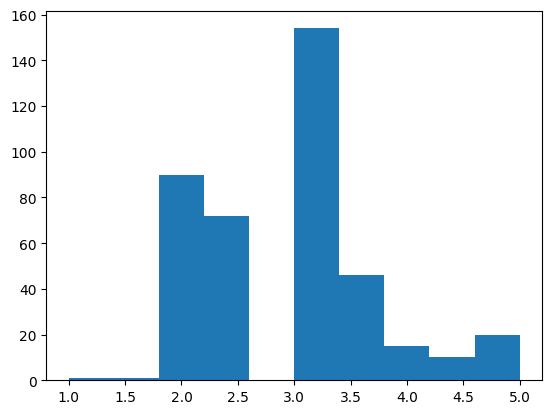

In [6]:
plt.hist(train_set['label'])

* Scores are heavily concentrated around `2-2.5` and `3-3.5`  
* Noticeable lows around `1.0-2.0` and `2.5-3.0`.
* There's a slight increase again at the higher end (`4.5-5`)
* The distribution of grammar score is specifically bimodal with two main cluster of scores → training data represents two distinct group of speakers or learners


Now, let's have a look at the descriptive statistics

In [7]:
train_set.describe()

,label
count,409.000000
mean,2.910758
std,0.766953
min,1.000000
25%,2.500000
50%,3.000000
75%,3.000000
max,5.000000


* Scoring ranges from `1-5` with standard deviation of 0.77
* The average grammar score is approximately 2.91
* The median grammar score is 3, with 75% of the scores being 3 or lower → indicates concentration of score below this value

(Optional) -> Given the non-normal distribution, future modeling efforts should consider techniques robust to multimodal data or potentially segment the data based on these inherent clusters for more targeted analysis.

### **Audio Preprocessing**

Time to create an **audio loading function** that loads an audio file and resamples it to a fixed sampling rate.

In [8]:
def load_audio(file_path, target_sr=16000):
  audio, sr = librosa.load(file_path, sr= target_sr)
  return audio, sr

#### But why `sr= 16000`?
* Using a **fixed sampling rate** ensures uniform temporal resolution across samples.
* sr = 16000 acts as a common speech-processing standard for reducing computational load
and that is more/less sufficient for speech characteristics

Let's perform a small sanity check by loading and inspecting one file

In [9]:
sample_file = train_set.iloc[0]['filename']
sample_path = os.path.join(train_audio_path, sample_file + '.wav')

audio, sr = load_audio(sample_path)

print(f"Sampling Rate: {sr}")
print(f"Audio Shape: {audio.shape}")
print(f"Duration (in seconds): {len(audio)/sr}")

/tmp/ipython-input-3497501810.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr= target_sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Sampling Rate: 16000
Audio Shape: (961195,)
Duration (in seconds): 60.0746875


Although the problem statement says that audio files are between `45-60s`, we'll still **verify and analyze the audio durations**

In [10]:
durations = []

for file_name in tqdm(train_set["filename"]):
    path = os.path.join(train_audio_path, file_name + '.wav')
    audio, sr = load_audio(path)
    durations.append(len(audio) / sr)

durations = np.array(durations)

  0%|          | 0/409 [00:00<?, ?it/s]/tmp/ipython-input-3497501810.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr= target_sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 1/409 [00:00<02:22,  2.85it/s]/tmp/ipython-input-3497501810.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr= target_sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 3/409 [00:01<03:54,  1.73it/s]/tmp/ipython-input-3497501810.py:

Let's see the distribution of audio durations for training set

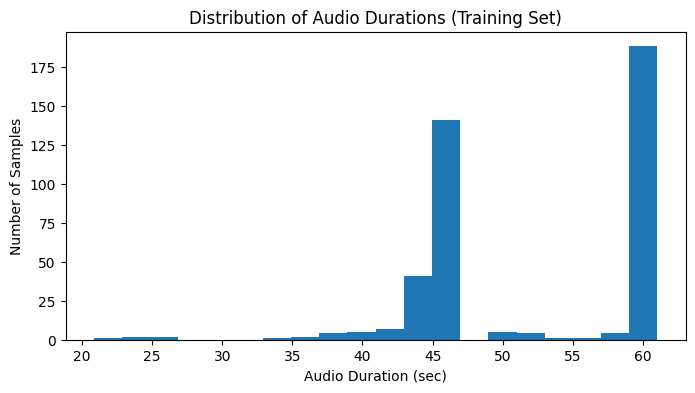

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(durations, bins=20)
plt.xlabel("Audio Duration (sec)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Audio Durations (Training Set)")
plt.show()

In [12]:
print(f"Min duration:{durations.min()}")
print(f"Max duration:{durations.max()}" )
print(f"Mean duration:{durations.mean()}")


Min duration:20.84
Max duration:61.04
Mean duration:51.691407548899754


* Heavy concentration of audio samples specifically around `45s` and `60s` respectively
* The average audio duration is approximately **`51s`**
* Majority of the audio samples lie in the range of **approximately 45-60 seconds**. Therefore, no trimming or padding is applied because samples are similar length and aggregation will handle variability

### **Feature Extraction**

#### But why the need of extracting features?
To convert variable-length audio signals into fixed-size numerical representations suitable for regression models. But again for that to happen, we'll need to extract Mel-Frequency Cepstral Coefficients(MFCCs).

#### What is MFCC?

More like a special 'fingerprint' of sound. They help computers understand speech by focusing on the unique qualities of sound that relate to how words are spoken, including:
*  **articulation** → how clearly someone speaks,
*  **fluency** → how smoothly their speech flows

They're widely used because they effectively capture the important parts of speech sound.

So, let's create the MFCC extraction function

In [13]:
def extract_mfcc(audio, sr, n_mfcc=20):
  mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
  mfcc_mean = np.mean(mfcc,axis=1)
  mfcc_std = np.std(mfcc,axis=1)
  features = np.concatenate([mfcc_mean,mfcc_std])
  return features

#### How this function works:
Basically extracts MFCC features from an audio signal and aggregates them over time.

`audio` + `sr` + `n_mfcc` ⟹ `features`

Doing this by taking audio time-series, sampling rate, no. of MFCC coefficients as inputs and returns an aggregated MFCC feature vector

Now, we'll be extracting features for training set

In [14]:
X_train = []
y_train = []

for idx, row in tqdm(train_set.iterrows(), total=len(train_set)):
    file_path = os.path.join(train_audio_path, row["filename"]+ '.wav')
    audio, sr = load_audio(file_path)
    features = extract_mfcc(audio, sr)
    X_train.append(features)
    y_train.append(row["label"])

X_train = np.array(X_train)
y_train = np.array(y_train)


  0%|          | 0/409 [00:00<?, ?it/s]/tmp/ipython-input-3497501810.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr= target_sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 1/409 [00:01<12:54,  1.90s/it]/tmp/ipython-input-3497501810.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr= target_sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 3/409 [00:02<04:09,  1.63it/s]/tmp/ipython-input-3497501810.py:

In [15]:
print(f"Feature matrix shape: {X_train.shape}")
print(f"Target shape:{y_train.shape}")

Feature matrix shape: (409, 40)
Target shape:(409,)


20 MFCC means + 20 MFCC stds = 40 features

Let's visualize the distribution of features.

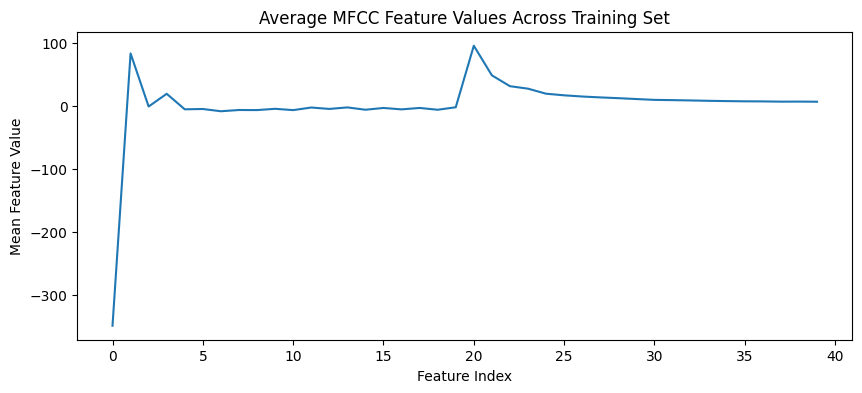

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(X_train.mean(axis=0))
plt.xlabel("Feature Index")
plt.ylabel("Mean Feature Value")
plt.title("Average MFCC Feature Values Across Training Set")
plt.show()

As we can see that:
* MFCC features are on different scales
* Thus, feature scaling will be applied before modeling

#### Let's breakdown the logic:
Since all audio samples have comparable durations (`45–60 seconds`), MFCC features are aggregated across time using summary statistics (mean and standard deviation). This produces a fixed-length representation while preserving overall spectral characteristics of speech.

### **Modelling & Evaluation**

We'll perform a train-validation split in ratio of 4:1

**i.e. 80% training data + 20% validation data**

In [17]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,test_size=0.2,random_state=42)


#### But why need of validation split?
* to assess generalization performance and
* detect the presence of overfitting

Scaling features is mandatory because MFCC features are on different scales.

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_scaled  = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

#### Why is feature scaling necessary?
Because it ensures that all MFCC coefficients contribute equally to the regression model

We'll be trying out **Ridge Regression as our baseline model** for this

In [19]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_tr_scaled, y_tr)

Ridge(random_state=42)

#### Why Ridge Regression?
Because,
* it is Linear
* it is Regularized
* very stable on moderate to small datasets
* easy to interpret

Next, let's make our individual predictions on training and validation set

In [20]:
y_tr_pred  = ridge_model.predict(X_tr_scaled)
y_val_pred = ridge_model.predict(X_val_scaled)

Calculating Metrics: RMSE

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
val_rmse   = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("Training RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)

Training RMSE: 0.6510485412721477
Validation RMSE: 0.7242366650311208


### What RMSE actually tells you?
The average magnitude of the errors in your predictions on any given dataset. Lower RMSE indicates that the model predictions are closer to the actual values.

* **Training RMSE ~ 0.65**
* Validation EMSE ~ 0.72

For e.g. Training RMSE of 0.65 means that, on average, the model's predictions of grammar scores are off by 0.65 points on the 0-5 scale

Calculating Metrics: Pearson Correlation

In [ ]:
from scipy.stats import pearsonr

train_pearson = pearsonr(y_tr, y_tr_pred)[0]
val_pearson   = pearsonr(y_val, y_val_pred)[0]

print("Training Pearson:", train_pearson)
print("Validation Pearson:", val_pearson)

Training Pearson: 0.5268221904036263
Validation Pearson: 0.43216543121450907


### What Pearson Correlation actually tells you?
Measures the linear relationship between model's predictions and the actual values. Higher value (towards 1) indicates positive linear relationship, lower value (towards -1) indicates negative linear relationship and 0 indicates no linear relationship at all

* Training Pearson ~ 0.53
* Validation Pearson ~ 0.43

For e.g. Validation Pearson of 0.43 means the model generally predicts higher scores for audios with higher actual grammar scores, and lower scores for audios with actual lower scores. But the strength of relationship can be improved.

Next, we'll show a scatterplot of Actual vs Predicted Grammar scores

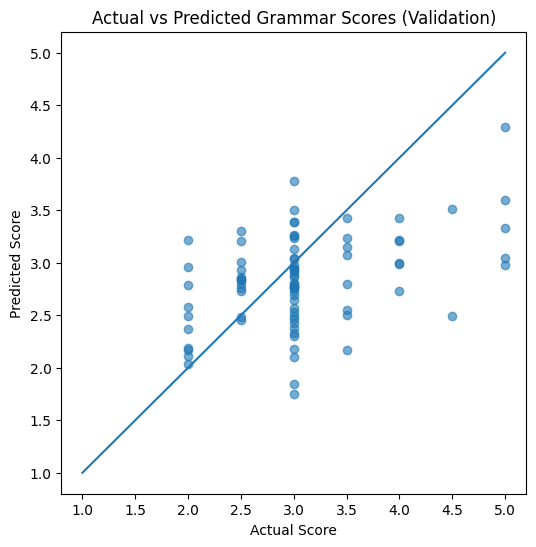

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([1, 5], [1, 5])
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Grammar Scores (Validation)")
plt.show()

* For actual scores ower than the mean(around 2.91), the model tends to overpredict.
* Conversely, for actual scores higher than the mean (above 3.5), this model tends to underpredict.
* Dense cluster of points around 3.0 mark, indicating that model performs relatively better for scores in the middle range.

Let's visualize how the prediction errors are actually distributed

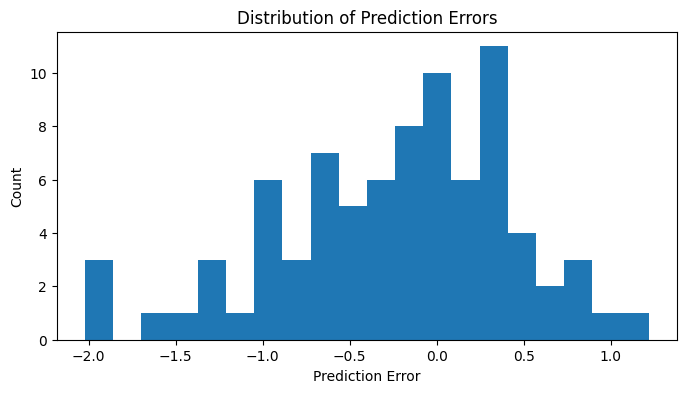

In [23]:
errors = y_val_pred - y_val

plt.figure(figsize=(8, 4))
plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.show()

* Presence of slight bias towards positive errors (i.e. model sometimes overpredicts). Noticeable peak in range of 0 to 0.5 indicating that model has a tendency to predict slightly higher than actual score in certain instances
* Significant count of negative errors around -0.5 to -1 and even -2. Indicates that model frequently underpredicts grammar scores, especially for higher actual values as observed in residuals plot.
* Distribution of errors is not perfectly symmetrical around zero and doesn't resemble a normal distribution.

####Model Interpretation: Ridge
1. Model shows a **tendency to predict scores closer to the mean**, which is expected given the bimodal distribution of the grammar scores in training data
2. Extreme low and high scores are **harder to predict accurately**, likely due to fewer samples in those regions.
3. **Small train–val gap** → good generalization
4. **Moderate Pearson** → model captures some ranking structure
5. **Linear model** → expected limitation on non-linear patterns

Trying a tree model for better scope of incremental improvement, not overfitting

In [25]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

rf_model = RandomForestRegressor(n_estimators=200,random_state=42)

rf_model.fit(X_tr, y_tr)
rf_val_pred = rf_model.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_val_pred))
rf_pearson = pearsonr(y_val, rf_val_pred)[0]

print("RF Validation RMSE:", rf_rmse)
print("RF Validation Pearson:", rf_pearson)

RF Validation RMSE: 0.7015741229549448
RF Validation Pearson: 0.4610181429234058


####Model Interpretation: Random Forest
1. Val RMSE ~ 0.70
2. Val Pearson ~ 0.46
3. Slight improvement over Ridge
4. Non-linear interactions help a bit
5. Still limited by feature expressiveness (MFCC aggregation)

#### But which one to choose and why?
⇒ **Ridge Regression** serves as a strong baseline due to its simplicity and regularization, showing stable generalization performance.

⇒ **Random Forest** provides a modest improvement in both RMSE and Pearson correlation, suggesting that non-linear relationships between aggregated MFCC features and grammar scores exist, although the overall performance remains constrained by the limited feature representation and dataset size.

So we'll
* Keep Ridge regression as baseline model.
* Random Forest is selected as final model due to improved validation performance

### **Error Analysis**

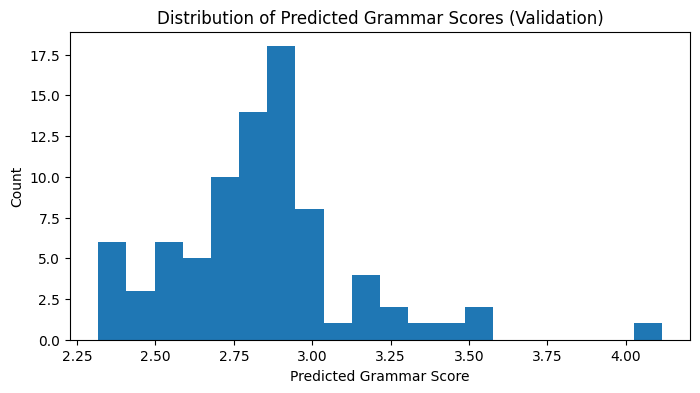

In [26]:
plt.figure(figsize=(8, 4))
plt.hist(rf_val_pred, bins=20)
plt.xlabel("Predicted Grammar Score")
plt.ylabel("Count")
plt.title("Distribution of Predicted Grammar Scores (Validation)")
plt.show()


* Predicted Grammar scores seem to form a cluster towards the mean(2.91)
* Absolute Extreme values (like 1 and 5) are not properly represented

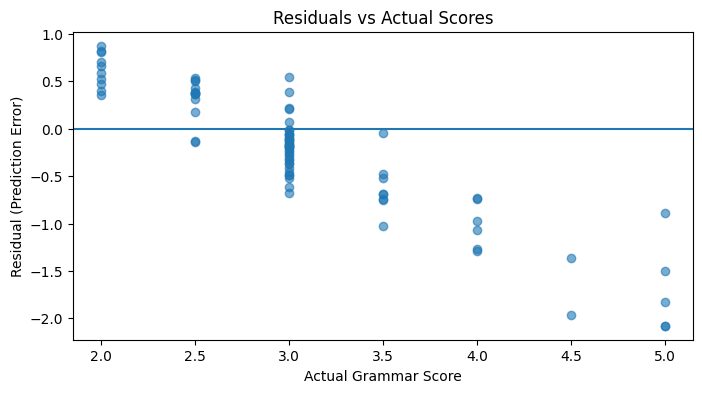

In [27]:
plt.figure(figsize=(8, 4))
plt.scatter(y_val, rf_val_pred - y_val, alpha=0.6)
plt.axhline(0)
plt.xlabel("Actual Grammar Score")
plt.ylabel("Residual (Prediction Error)")
plt.title("Residuals vs Actual Scores")
plt.show()


* Residuals (prediction errors) are not randomly scattered around zero, that is ideal for a well-performing model. Instead there's a clear pattern
* For actual grammar scores between 2 and 2.5, most residuals are positive, means the model generally overpredicts these lower scores.
* Negative residuals appears to increase for higher actual scores (e.g 4.5 and 5), indicating that model has more difficulty predicting very high grammar scores accurately.

### **Limitations & Future Work**

#### What can be some potential limitations?
→ grammar is fundamentally a linguistic property of text (deals more with text)

→ audio-only models learn indirect correlates such as fluency and articulation rather than explicit grammatical correctness

#### Can we improve anything via future work?
→ Advanced feature engineering e.g. capturing some deeper more complicated features related to grammar, fluency, pitch, speaking rate, rythm

→ Utilize pre-trained or some higher self-supervised models to capture richer representations of speech

→ Much larger dataset / Data Augmentation or applying some resampling techniques for making it easy to learn harder charactersitics

→ Ensemble methods / Neural Networks for better handling non-linearity and data distribution

### **Prediction on Test Set**

In [28]:
X_test = []

for file_name in tqdm(test_set["filename"]):
    path = os.path.join(test_audio_PATH, file_name + '.wav')
    audio, sr = load_audio(path)
    features = extract_mfcc(audio, sr)
    X_test.append(features)

X_test = np.array(X_test)


  3%|▎         | 6/197 [00:07<03:43,  1.17s/it]/tmp/ipython-input-3497501810.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr= target_sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 13/197 [00:14<02:50,  1.08it/s]/tmp/ipython-input-3497501810.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr= target_sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 33/197 [00:36<02:54,  1.06s/it]/tmp/ipython-input-3497

In [29]:
rf_final = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_final.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [30]:
test_preds = rf_final.predict(X_test)

In [31]:
test_preds

array([2.665 , 2.87  , 2.885 , 3.69  , 2.905 , 3.16  , 3.035 , 2.5975,
       2.975 , 2.8725, 2.695 , 3.385 , 3.065 , 3.58  , 2.725 , 2.895 ,
       2.485 , 2.7575, 3.545 , 2.9775, 3.255 , 3.1675, 2.5825, 3.51  ,
       2.7825, 2.71  , 2.5925, 3.3925, 2.585 , 2.8475, 2.855 , 2.8775,
       3.82  , 3.5175, 2.7325, 2.73  , 2.7625, 3.47  , 2.7775, 2.835 ,
       3.21  , 3.3525, 2.7475, 3.2025, 3.2475, 3.335 , 2.8775, 3.17  ,
       2.7075, 2.6175, 2.8025, 3.135 , 2.82  , 2.745 , 3.02  , 3.26  ,
       3.165 , 2.8575, 2.795 , 3.06  , 2.6475, 3.31  , 3.085 , 3.6575,
       3.505 , 2.7125, 3.2775, 3.1325, 2.86  , 3.0125, 2.7625, 2.9675,
       2.4925, 3.05  , 2.8475, 2.9375, 2.6225, 2.995 , 3.0075, 2.9775,
       3.085 , 3.72  , 2.9   , 3.6   , 2.8825, 2.79  , 2.925 , 3.045 ,
       3.4825, 2.7725, 2.82  , 2.8575, 3.2875, 2.5275, 3.5075, 4.1525,
       3.2275, 3.1575, 2.55  , 3.2625, 3.435 , 2.745 , 2.98  , 3.17  ,
       2.615 , 2.96  , 3.1825, 2.635 , 4.375 , 3.2175, 2.98  , 2.865 ,
      

In [32]:
test_preds = np.clip(test_preds, 0, 5)

In [33]:
test_preds

array([2.665 , 2.87  , 2.885 , 3.69  , 2.905 , 3.16  , 3.035 , 2.5975,
       2.975 , 2.8725, 2.695 , 3.385 , 3.065 , 3.58  , 2.725 , 2.895 ,
       2.485 , 2.7575, 3.545 , 2.9775, 3.255 , 3.1675, 2.5825, 3.51  ,
       2.7825, 2.71  , 2.5925, 3.3925, 2.585 , 2.8475, 2.855 , 2.8775,
       3.82  , 3.5175, 2.7325, 2.73  , 2.7625, 3.47  , 2.7775, 2.835 ,
       3.21  , 3.3525, 2.7475, 3.2025, 3.2475, 3.335 , 2.8775, 3.17  ,
       2.7075, 2.6175, 2.8025, 3.135 , 2.82  , 2.745 , 3.02  , 3.26  ,
       3.165 , 2.8575, 2.795 , 3.06  , 2.6475, 3.31  , 3.085 , 3.6575,
       3.505 , 2.7125, 3.2775, 3.1325, 2.86  , 3.0125, 2.7625, 2.9675,
       2.4925, 3.05  , 2.8475, 2.9375, 2.6225, 2.995 , 3.0075, 2.9775,
       3.085 , 3.72  , 2.9   , 3.6   , 2.8825, 2.79  , 2.925 , 3.045 ,
       3.4825, 2.7725, 2.82  , 2.8575, 3.2875, 2.5275, 3.5075, 4.1525,
       3.2275, 3.1575, 2.55  , 3.2625, 3.435 , 2.745 , 2.98  , 3.17  ,
       2.615 , 2.96  , 3.1825, 2.635 , 4.375 , 3.2175, 2.98  , 2.865 ,
      

In [ ]:
submission = pd.DataFrame({
    "filename": test_set["filename"],
    "label": test_preds
})

submission.to_csv("/content/drive/MyDrive/grammer-scoring-engine/submission.csv", index=False)

### **Project Report: Grammar Scoring Engine from Voice**

This project aimed to develop a grammar scoring engine that takes an audio file as input and outputs a continuous grammar score ranging from 0 to 5. The solution involved several key stages:

**1. Approach & Problem Framing:**
  *   The core task was to predict a continuous grammar score from spoken audio samples.
  *   Initially, 'grammar from voice' was interpreted as converting spoken text to text and then scoring, but the focus shifted to directly scoring speech characteristics related to grammar.

**2. Data Preprocessing:**
  *   **Audio Loading and Resampling:** Audio files were loaded using `librosa` and resampled to a fixed sampling rate of 16 kHz. This standardized the audio data and reduced computational load.
  *   **Duration Analysis:** A quick analysis revealed that most audio samples were concentrated around 45-60 seconds, with an average duration of approximately 51 seconds. Given this similarity, no explicit padding or trimming was applied.

**3. Feature Extraction:**
  *   **MFCCs (Mel-Frequency Cepstral Coefficients):** The primary features extracted were MFCCs, which are effective in capturing vocal articulation and fluency. 20 MFCC coefficients were calculated for each audio segment.
  *   **Feature Aggregation:** To create fixed-length feature vectors from variable-length audio, the mean and standard deviation of these 20 MFCCs were computed across the entire audio signal, resulting in a 40-feature vector per sample.
  *   **Feature Scaling:** Prior to modeling, `StandardScaler` was applied to ensure all MFCC features contributed equally to the models.

**4. Pipeline Architecture:**
  *   **Train-Validation Split:** The training dataset was split into an 80% training set and a 20% validation set to assess generalization performance and detect overfitting.
  *   **Model Selection:**
      *   **Ridge Regression:** Chosen as a linear, regularized baseline model, known for stability on moderate datasets. It provided initial performance metrics (Training RMSE: 0.65, Validation RMSE: 0.72; Training Pearson: 0.53, Validation Pearson: 0.43).
      *   **Random Forest Regressor:** Selected as the final model due to its ability to capture non-linear relationships. It showed a slight improvement over Ridge Regression (Validation RMSE: 0.70, Validation Pearson: 0.46).

**5. Evaluation Results:**
  *   **RMSE:** Both models yielded similar RMSE values, indicating that predictions were, on average, off by about 0.7 points on the 0-5 scale. Particulary, ***Training RMSE was around ~0.65***
  *   **Pearson Correlation:** A moderate positive correlation (around 0.43-0.46) was observed, suggesting that the models capture some linear relationship between predicted and actual scores, though with room for improvement in strength.
  *   **Error Analysis:** Residual plots showed a tendency for both models to overpredict lower scores and underpredict higher scores, indicating a bias towards the mean score in predictions. This is partly attributed to the bimodal distribution of grammar scores in the training data.

**6. Limitations & Future Work:**
  *   **Limitations:** The current audio-only approach primarily captures indirect correlates of grammar (fluency, articulation) rather than explicit linguistic correctness. The dataset size and the limited expressiveness of aggregated MFCCs also pose constraints.
  *   **Future Work:** Suggestions for improvement include advanced feature engineering (e.g., pitch, speaking rate), leveraging pre-trained self-supervised speech models, data augmentation, and exploring more complex models like neural networks.